In [22]:
%matplotlib inline
# Common Imports
import numpy as np
#Pandas for creating dataframes
import pandas as pd
#Sklearn
from sklearn import preprocessing
#OS moduled for file oprations
import os
#CSV module
import csv
#Plotting
import matplotlib.pyplot as plt
import shutil
import glob

In [62]:
#Base Folder Paths
base_folder_name = 'converted'
test_folder_name = 'test3'
base_path = os.path.join(base_folder_name, test_folder_name)
#Normal Sample and cluster paths
sample_dir_name = 'samp'
sample_path = os.path.join(base_path, sample_dir_name)
#If sample folder exist
if os.path.isdir(sample_path):
    #Test and Train data Folders
    train_path = os.path.join(base_path, sample_dir_name+'_train')
    os.makedirs(train_path, exist_ok=True)
    test_path = os.path.join(base_path, sample_dir_name+'_test')
    os.makedirs(test_path, exist_ok=True)
    
    train_cluster_path = os.path.join(train_path, 'cluster')
    test_cluster_path = os.path.join(test_path, 'cluster')
    os.makedirs(train_cluster_path, exist_ok=True)
    os.makedirs(test_cluster_path, exist_ok=True)
#Defining features
features = [1, 6, 17] #(ICMP:1, TCP:6, UDP:17)    

In [51]:
#Create feature vector corrosponding to each cluster. 
#This feature vector would be used to define boundray using One Class SVM for the cluster.
def get_clusters_feature_vectors(cluster_path):
    cluster_dict = dict()
    filenames = sorted(glob.glob(os.path.join(cluster_path,'*')),  key=os.path.getmtime)
    first = True
    for filename in filenames:
        if first:
            df = pd.read_csv(filename, index_col=0)
            first = False
        else:
            temp_df = pd.read_csv(filename, index_col=0)
            df = df.append(temp_df) 
    df = df.reset_index().set_index(['cluster','ip'])
    clusters = df.index.get_level_values(0).unique()
    for c in clusters:
        cluster_dict[c] = df.loc[c].values
    return cluster_dict

In [52]:
def plot_outlier_detecton(X_train, clf, title):
    
    xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.title("Outlier Detection:" + str(title))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
    #plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
    
    s = 40
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s, edgecolors='k')
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([a.collections[0], b1],
           ["learned frontier", "training observations"],
           loc="upper left")
    plt.show()

In [53]:
#SKlearn SVM
from sklearn import svm
from sklearn.neighbors import LocalOutlierFactor
def one_class_svm(feature_vector, cluster):
    X_train = feature_vector
    #Get scaler
    scaler = preprocessing.StandardScaler().fit(X_train)
    #Transform Traning data
    X_trans = scaler.transform(X_train)
    # fit the model
    clf = svm.OneClassSVM(nu=0.01, kernel="rbf", gamma=0.1)
    clf.fit(X_trans)
    clf.name = 'svm'
    #Plot the graph
    title = ' Cluster '+ str(cluster)
    plot_outlier_detecton(X_trans, clf, title)
    return clf, scaler

/home/arpit/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


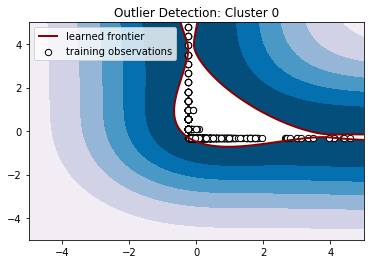

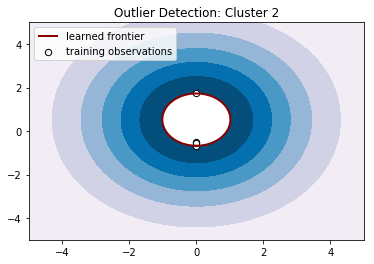

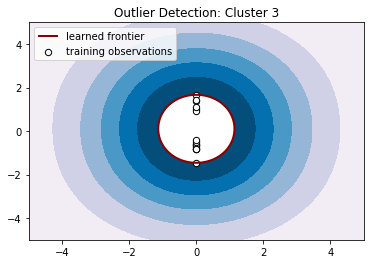

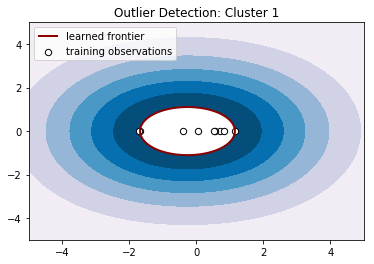

In [56]:
cluster_feature_dict = get_clusters_feature_vectors(train_cluster_path)
clf_dict = dict()
scaler_dict = dict()
for cluster, df in cluster_feature_dict.items():
    clf_dict[cluster], scaler_dict[cluster] = one_class_svm(df, cluster)

In [59]:
#Predict for the give destination if it is normal or not
X_test = [[658,0]]#[[1491,18]]
X_test_tran = scaler_dict[0].transform(X_test)
clf_dict[0].predict(X_test_tran)

array([-1])

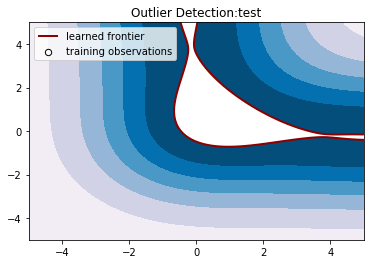

In [61]:
plot_outlier_detecton(X_test_tran, clf_dict[0], 'test')